<a href="https://colab.research.google.com/github/KakaCheng/tibame_group_project/blob/main/%5BKaggle%5DHumanEmotion_20211207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#讀檔
import pandas as pd
import zipfile
data = pd.read_csv("/content/drive/MyDrive/[Kaggle] 題目練習/Human_Emotion/fer2013.csv")
# data = pd.read_csv("/content/drive/MyDrive/fer2013.csv")

data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
interest_item = [0, 3, 4, 6]
data = data[data["emotion"].isin(interest_item)]

In [ ]:
data.Usage.value_counts()

Training       21005
PublicTest      2622
PrivateTest     2590
Name: Usage, dtype: int64

In [ ]:
interest_item_trans = {interest_item[i] : i for i in range(len(interest_item))}
interest_item_trans_inv = {i : interest_item[i] for i in range(len(interest_item))}

# for i in range(len(data["emotion"])):
#   tmp = data["emotion"][i]
#   data["emotion"][i] = interest_item_trans[tmp]

# data.head(10)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

x_train = data["pixels"][(data.Usage == "Training") | (data.Usage == "PublicTest")]
y_train = data["emotion"][(data.Usage == "Training") | (data.Usage == "PublicTest")]

x_test = data["pixels"][(data.Usage == "PrivateTest")]
y_test = data["emotion"][(data.Usage == "PrivateTest")]

le = LabelEncoder()
y_train_cat = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train_cat)

y_test_cat = le.transform(y_test)
y_test_cat = to_categorical(y_test_cat)

np.save("label.npy",le.classes_)

In [ ]:
import numpy as np
x_train = np.array(list(map(str.split, x_train)), np.float32) #切割字串並轉成float型態
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)#資料個數, 48(x), 48(y), 1(channel)

x_test = np.array(list(map(str.split, x_test)), np.float32) #切割字串並轉成float型態
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)#資料個數, 48(x), 48(y), 1(channel)

x_train_nor = x_train / 255
x_test_nor = x_test / 255

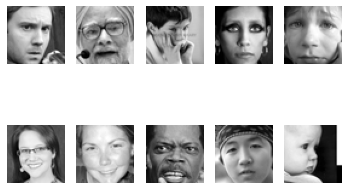

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.axis("off")
  plt.imshow(x_train[i][:,:,0], cmap='gray')
plt.show()

In [ ]:
import cv2
import numpy as np
import os

def get_HOG_desc(input_img, filename):
  output = []
  #檢查檔案是否存在
  if os.path.isfile(filename):
    print("{}檔案存在".format(filename))
    output = np.load(filename)
  else:
    #取得
    print("{}檔案不存在".format(filename))
    hog = cv2.HOGDescriptor()
    for i in input_img:
      i = i.astype("uint8")[:,:,0]
      i_ = cv2.resize(i, (64,128))
      output.append(hog.compute(i_))
    output = np.array(output)
    np.save(filename, output)
  return output

xtest_hog_feats = []
xtrain_hog_feats = []

xtrain_hog_feats = get_HOG_desc(x_train, "xtrain_hog.npy")
xtest_hog_feats = get_HOG_desc(x_test, "xtest_hog.npy")

print("xtrain_hog_feats.shape = {}".format(xtrain_hog_feats.shape))
print("xtest_hog_feats.shape = {}".format(xtest_hog_feats.shape))


xtrain_hog.npy檔案不存在
xtest_hog.npy檔案不存在
xtrain_hog_feats.shape = (23627, 3780, 1)
xtest_hog_feats.shape = (2590, 3780, 1)


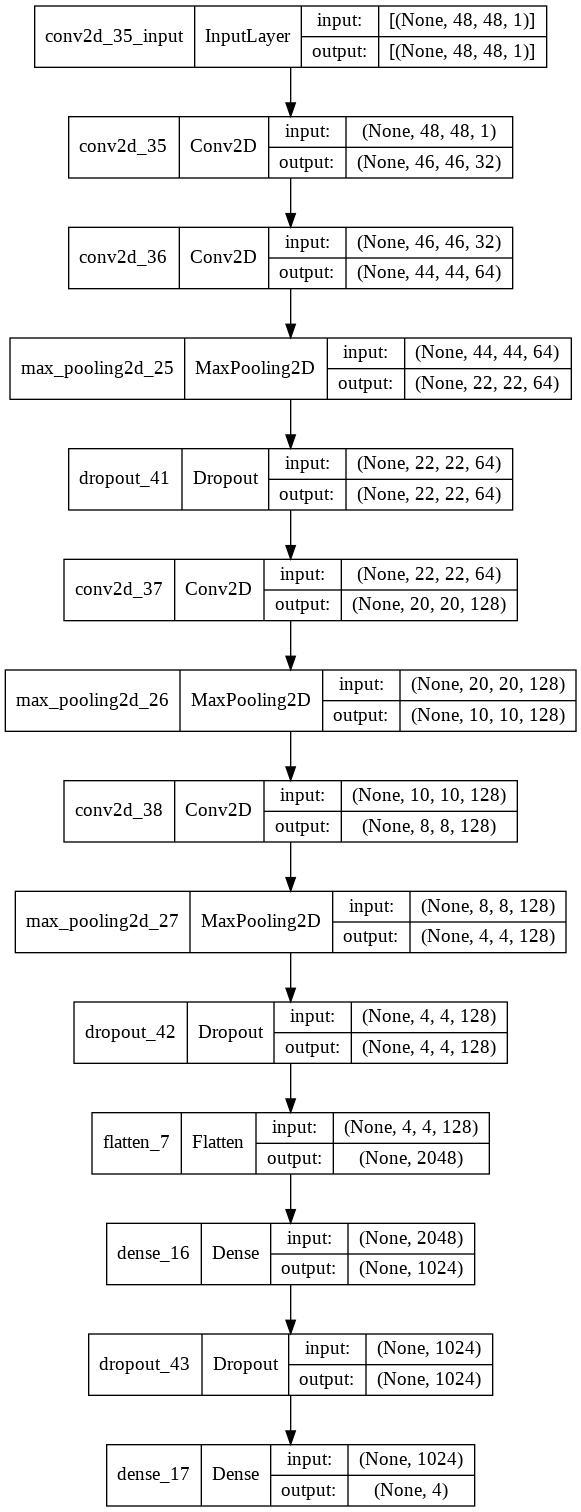

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model

#input
i1 = Input(shape = (48, 48, 1))
i2 = Input(shape = xtrain_hog_feats[0].shape)

# ##Descriptor1
# #1
# x = Conv2D(64, (3, 3), activation='elu', padding="same")(i1)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.3)(x)
# #2
# x = Conv2D(128, (3, 3), activation='elu', padding="same")(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.3)(x)
# #3
# x = Conv2D(256, (3, 3), activation='elu', padding="same")(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.3)(x)
# #4
# x = Conv2D(512, (3, 3), activation='elu', padding="same")(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.3)(x)

# ##MLP1
# # x5_1 = Flatten()(x4_6)
# # x5_2 = Dense(512, activation = "elu")(x5_1)
# # x5_3 = BatchNormalization()(x5_2)
# # x5_4 = Dropout(0.4)(x5_3)

# x = Flatten()(x)
# x = Dense(128, activation = "elu")(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# ##MLP3
# result = Dense(4 , activation = "softmax")(x)

# #gen model
# model = Model(inputs = [i1], outputs = [result], name = "model_20211208")

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

plot_model(model, to_file="model_20211208.png", show_shapes=True)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(loss = CategoricalCrossentropy(),
            optimizer = "adam",
            metrics = ["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience = 5, restore_best_weights=True),
    ModelCheckpoint("model.h5", save_best_only=True)
]

model.fit(x_train_nor,
     y_train_cat,
     batch_size=128,
     epochs=100,
     validation_split=0.1,
     verbose=2,
     callbacks=callbacks)

Epoch 1/100
167/167 - 10s - loss: 1.3171 - accuracy: 0.3771 - val_loss: 1.2051 - val_accuracy: 0.4786 - 10s/epoch - 62ms/step
Epoch 2/100
167/167 - 8s - loss: 1.1265 - accuracy: 0.5047 - val_loss: 1.0431 - val_accuracy: 0.5544 - 8s/epoch - 50ms/step
Epoch 3/100
167/167 - 8s - loss: 1.0141 - accuracy: 0.5633 - val_loss: 0.9632 - val_accuracy: 0.5865 - 8s/epoch - 50ms/step
Epoch 4/100
167/167 - 8s - loss: 0.9453 - accuracy: 0.5973 - val_loss: 0.9236 - val_accuracy: 0.6018 - 8s/epoch - 50ms/step
Epoch 5/100
167/167 - 8s - loss: 0.9035 - accuracy: 0.6181 - val_loss: 0.8937 - val_accuracy: 0.6153 - 8s/epoch - 50ms/step
Epoch 6/100
167/167 - 8s - loss: 0.8659 - accuracy: 0.6383 - val_loss: 0.8866 - val_accuracy: 0.6234 - 8s/epoch - 50ms/step
Epoch 7/100
167/167 - 8s - loss: 0.8342 - accuracy: 0.6537 - val_loss: 0.8480 - val_accuracy: 0.6454 - 8s/epoch - 50ms/step
Epoch 8/100
167/167 - 8s - loss: 0.8059 - accuracy: 0.6658 - val_loss: 0.8396 - val_accuracy: 0.6428 - 8s/epoch - 50ms/step
Epoch 

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pre = model.predict(x_test_nor)
pre_inv = [emotion_label_to_text[i] for i in le.inverse_transform(pre.argmax(axis=1))]
y_test_cat_inv = [emotion_label_to_text[i] for i in le.inverse_transform(y_test_cat.argmax(axis=1))]

mat = confusion_matrix(y_test_cat_inv, pre_inv)
pd.DataFrame(mat,
      index=["{}(正確)".format(emotion_label_to_text[i]) for i in interest_item],
      columns=["{}(預測)".format(emotion_label_to_text[i]) for i in interest_item])

,anger(預測),happiness(預測),sadness(預測),neutral(預測)
anger(正確),282,39,68,102
happiness(正確),19,786,33,41
sadness(正確),40,56,387,143
neutral(正確),73,59,120,342


正確率: 0.6938223938223939


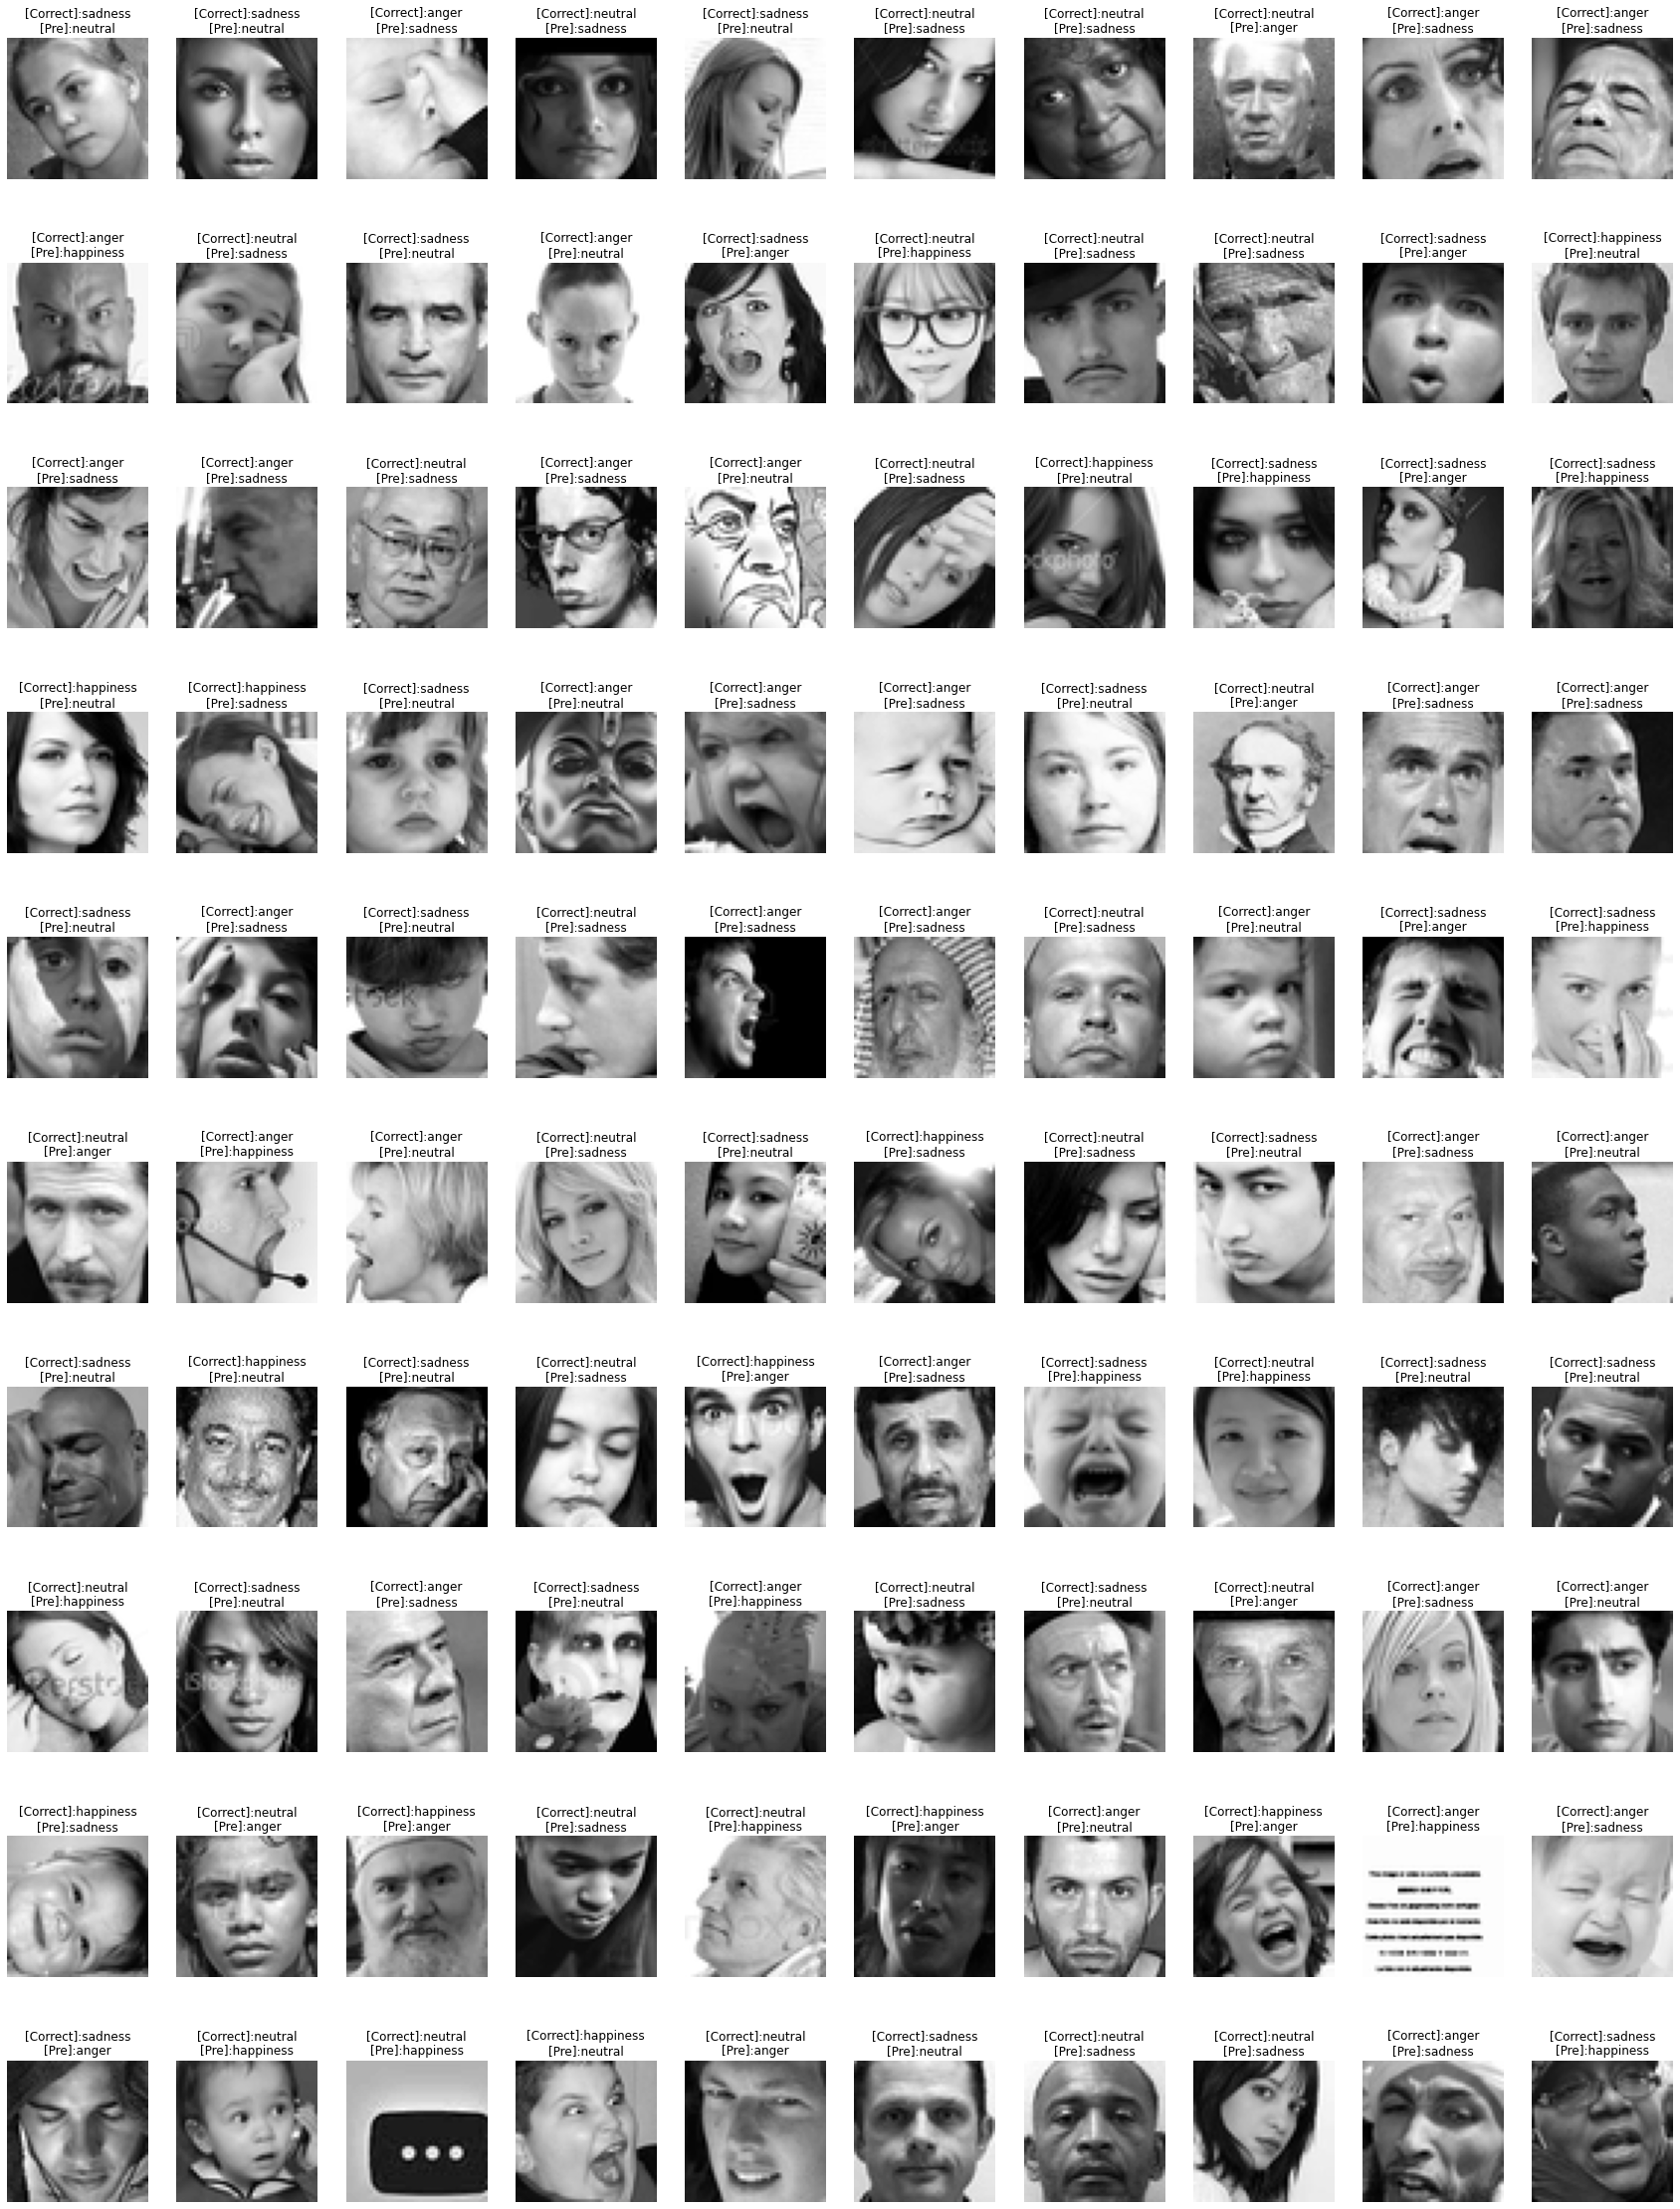

In [ ]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre.argmax(axis=1) != y_test_cat.argmax(axis=1))[0]

print("正確率: {}".format((pre.shape[0] - idx.shape[0])/pre.shape[0]))
idx = idx[:100]

pre_false_label = [y_test_cat_inv[i] for i in idx]
pre_false_pre = [pre_inv[i] for i in idx]

pre_false_img = x_test[idx].reshape(len(idx), 48, 48)
# pre_false_img = x_test[idx].reshape(48, 48)

plt.figure(figsize=(30, 45))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[Correct]:{}\n[Pre]:{}".format(pre_false_label[i], pre_false_pre[i])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i], cmap = "gray")